![](https://2rdnmg1qbg403gumla1v9i2h-wpengine.netdna-ssl.com/wp-content/uploads/sites/3/2014/04/brainFacts-579411100-770x533-1-745x490.jpg)

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Problem in hand : Given EEG data from subjects who were watching movies, let's try to predict the emotional state of a subject during a given movie.

### Importing necessary libraries

In [67]:
# TensorFlow 1.x compatibility mode
import tensorflow.compat.v1 as tf

# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Sklearn imports
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# TensorFlow and Keras imports
from tensorflow.keras import layers, optimizers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, LSTM, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical


### Reading EEG data with feature extracted

In [68]:
#  TP9,  AF7,  AF8, and  TP10
data = pd.read_csv("/content/drive/MyDrive/eeg_emotions_classification/emotions.csv")
print(data.info())
# print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2132 entries, 0 to 2131
Columns: 2549 entries, # mean_0_a to label
dtypes: float64(2548), object(1)
memory usage: 41.5+ MB
None


In [69]:
data

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.620,30.3,-356.0,15.60,26.3,1.070,0.411,-15.700,2.060,3.15,...,23.50,20.300,20.300,23.50,-215.0,280.00,-162.00,-162.00,280.00,NEGATIVE
1,28.800,33.1,32.0,25.80,22.8,6.550,1.680,2.880,3.830,-4.82,...,-23.30,-21.800,-21.800,-23.30,182.0,2.57,-31.60,-31.60,2.57,NEUTRAL
2,8.900,29.4,-416.0,16.70,23.7,79.900,3.360,90.200,89.900,2.03,...,462.00,-233.000,-233.000,462.00,-267.0,281.00,-148.00,-148.00,281.00,POSITIVE
3,14.900,31.6,-143.0,19.80,24.3,-0.584,-0.284,8.820,2.300,-1.97,...,299.00,-243.000,-243.000,299.00,132.0,-12.40,9.53,9.53,-12.40,POSITIVE
4,28.300,31.3,45.2,27.30,24.5,34.800,-5.790,3.060,41.400,5.52,...,12.00,38.100,38.100,12.00,119.0,-17.60,23.90,23.90,-17.60,NEUTRAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2127,32.400,32.2,32.2,30.80,23.4,1.640,-2.030,0.647,-0.121,-1.10,...,-21.70,0.218,0.218,-21.70,95.2,-19.90,47.20,47.20,-19.90,NEUTRAL
2128,16.300,31.3,-284.0,14.30,23.9,4.200,1.090,4.460,4.720,6.63,...,594.00,-324.000,-324.000,594.00,-35.5,142.00,-59.80,-59.80,142.00,POSITIVE
2129,-0.547,28.3,-259.0,15.80,26.7,9.080,6.900,12.700,2.030,4.64,...,370.00,-160.000,-160.000,370.00,408.0,-169.00,-10.50,-10.50,-169.00,NEGATIVE
2130,16.800,19.9,-288.0,8.34,26.0,2.460,1.580,-16.000,1.690,4.74,...,124.00,-27.600,-27.600,124.00,-656.0,552.00,-271.00,-271.00,552.00,NEGATIVE


### Viewing a sample of time series data

In [70]:
fft_data = data.loc[:,'fft_0_b':'fft_749_b']

In [71]:
fft_data

,fft_0_b,fft_1_b,fft_2_b,fft_3_b,fft_4_b,fft_5_b,fft_6_b,fft_7_b,fft_8_b,fft_9_b,...,fft_740_b,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b
0,-508.0,438.00,-222.00,-222.00,438.00,143.0,59.40,5.05,5.05,59.40,...,74.3,23.50,20.300,20.300,23.50,-215.0,280.00,-162.00,-162.00,280.00
1,126.0,-4.00,7.42,7.42,-4.00,81.6,-22.30,35.30,35.30,-22.30,...,130.0,-23.30,-21.800,-21.800,-23.30,182.0,2.57,-31.60,-31.60,2.57
2,-85.9,361.00,-62.20,-62.20,361.00,-558.0,684.00,-152.00,-152.00,684.00,...,-534.0,462.00,-233.000,-233.000,462.00,-267.0,281.00,-148.00,-148.00,281.00
3,69.5,3.89,12.10,12.10,3.89,-188.0,274.00,-200.00,-200.00,274.00,...,-183.0,299.00,-243.000,-243.000,299.00,132.0,-12.40,9.53,9.53,-12.40
4,226.0,-27.40,147.00,147.00,-27.40,301.0,-8.48,138.00,138.00,-8.48,...,114.0,12.00,38.100,38.100,12.00,119.0,-17.60,23.90,23.90,-17.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2127,105.0,3.37,29.20,29.20,3.37,151.0,-19.40,8.89,8.89,-19.40,...,155.0,-21.70,0.218,0.218,-21.70,95.2,-19.90,47.20,47.20,-19.90
2128,-23.0,202.00,-81.60,-81.60,202.00,-345.0,404.00,-205.00,-205.00,404.00,...,-661.0,594.00,-324.000,-324.000,594.00,-35.5,142.00,-59.80,-59.80,142.00
2129,-288.0,312.00,-259.00,-259.00,312.00,-186.0,276.00,-199.00,-199.00,276.00,...,-232.0,370.00,-160.000,-160.000,370.00,408.0,-169.00,-10.50,-10.50,-169.00
2130,109.0,2.48,49.00,49.00,2.48,-230.0,216.00,-92.40,-92.40,216.00,...,-99.7,124.00,-27.600,-27.600,124.00,-656.0,552.00,-271.00,-271.00,552.00


<Axes: >

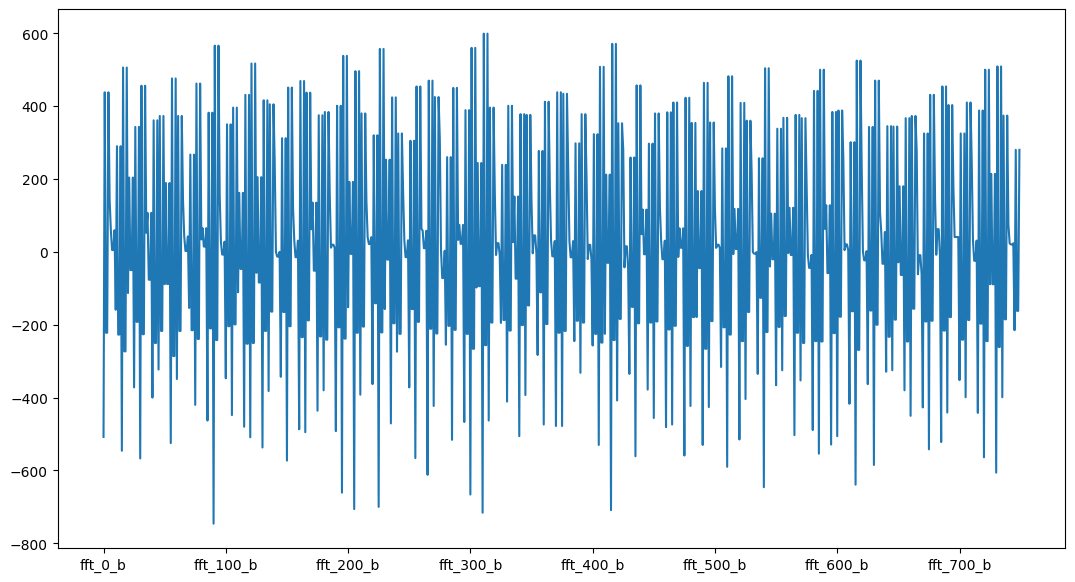

In [72]:
fft_data.iloc[0,:].plot(figsize=(13,7))

### Encoding the 3 distinct labels

The 3 labels are : "NEGATIVE", "NEUTRAL" and "POSITIVE".

In [73]:
# Assuming 'data' is your DataFrame and 'label' is the target column
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['label'] = le.fit_transform(data['label'])  # Convert labels to integers

# Retrieving the mapping of classes to their corresponding integer values
class_mapping = {index: label for index, label in enumerate(le.classes_)}

print("Class Mapping:")
for index, label in class_mapping.items():
    print(f"{index}: {label}")


# Spliting data into features and labels
X = data.drop(columns=['label']).values
y = data['label'].values

# Converting y to one-hot encoding
y = to_categorical(y, num_classes=3)

Class Mapping:
0: NEGATIVE
1: NEUTRAL
2: POSITIVE


In [74]:
print(X.shape)
print(y.shape)

(2132, 2548)
(2132, 3)


### Defining necessary features for model training.

In [75]:

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=48)
X_train = np.array(X_train).reshape((X_train.shape[0],X_train.shape[1],1))
X_test = np.array(X_test).reshape((X_test.shape[0],X_test.shape[1],1))


In [76]:
print(X_train.shape)
print(y_train)

(1492, 2548, 1)
[[0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]


### Defining the Model's architecture

In [77]:
inputs = tf.keras.Input(shape=(X_train.shape[1],1))

lstm = tf.keras.layers.LSTM(256, return_sequences=True)(inputs)
flat = Flatten()(lstm)
outputs = Dense(3, activation='softmax')(flat)

model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 2548, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 2548, 256)           │         264,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 652288)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 3)                   │       1,956,867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,221,059 (8.47 MB)

 Trainable params: 2,221,059 (8.47 MB)

 Non-trainable params: 0 (0.00 B)

### Plotting the model

In [78]:
# tf.keras.utils.plot_model(model)

### Training the model.

The loss function used will be 'Categorical_CrossEntropy'. We will be using callback functions like Early_Stopping to avoid overfitting and lr_scheduler to change the learning rate while model trains.

We will be training for 9 epochs starting with learning_rate = 0.001 and batch_size = 64.

In [79]:
def train_model(model,x_train, y_train, save_to, epoch = 2):

        opt_adam = optimizers.Adam(learning_rate=0.001)

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
        mc = ModelCheckpoint(save_to + '_best_model.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.001 * np.exp(-epoch / 10.))

        model.compile(optimizer=opt_adam,
                  loss=['categorical_crossentropy'],
                  metrics=['accuracy'])

        history = model.fit(x_train,y_train,
                        batch_size=32,
                        epochs=epoch,
                        validation_split=0.1,
                        callbacks=[es,mc,lr_schedule])

        saved_model = load_model(save_to + '_best_model.keras')

        return model,history

In [80]:
model,history = train_model(model, X_train, y_train, save_to='/content/drive/MyDrive/eeg_emotions_classification/', epoch = 9)

Epoch 1/9
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.6551 - loss: 20.6895
Epoch 1: val_accuracy improved from -inf to 0.94000, saving model to /content/drive/MyDrive/eeg_emotions_classification/_best_model.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 0.6584 - loss: 20.4690 - val_accuracy: 0.9400 - val_loss: 2.1322 - learning_rate: 0.0010
Epoch 2/9
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9258 - loss: 1.6841
Epoch 2: val_accuracy improved from 0.94000 to 0.94667, saving model to /content/drive/MyDrive/eeg_emotions_classification/_best_model.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9263 - loss: 1.6709 - val_accuracy: 0.9467 - val_loss: 1.0286 - learning_rate: 9.0484e-04
Epoch 3/9
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.9820 - loss: 0.2388
Epoch 3: val_accuracy improved from 0.94667 to 0.98000, saving model to /content/drive/MyDrive/eeg_emotions_classification/_best_model.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/

### Plotting the validation curves

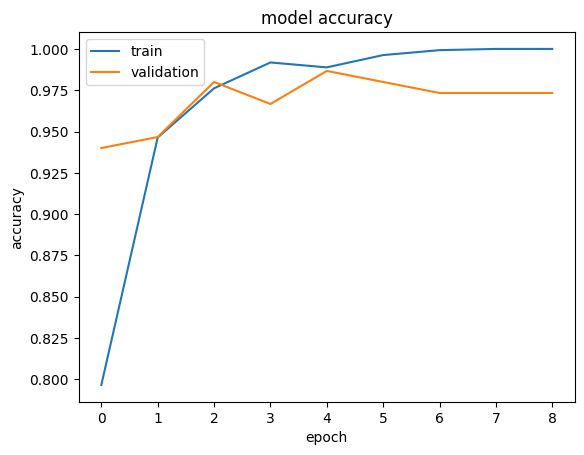

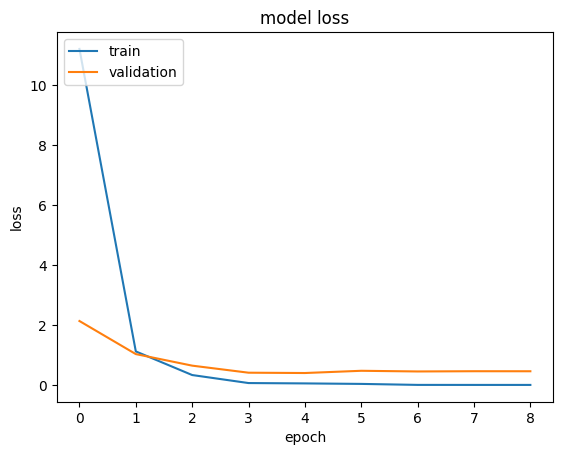

In [81]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
print("\n")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Evaluating the model

1. Test accuracy

In [82]:
model_acc = model.evaluate(X_test, y_test, verbose=0)[1]
print("Test Accuracy: {:.3f}%".format(model_acc * 100))

Test Accuracy: 98.281%


2. Confusion matrix along with classification reports (includes metrics like precision, F1-score)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


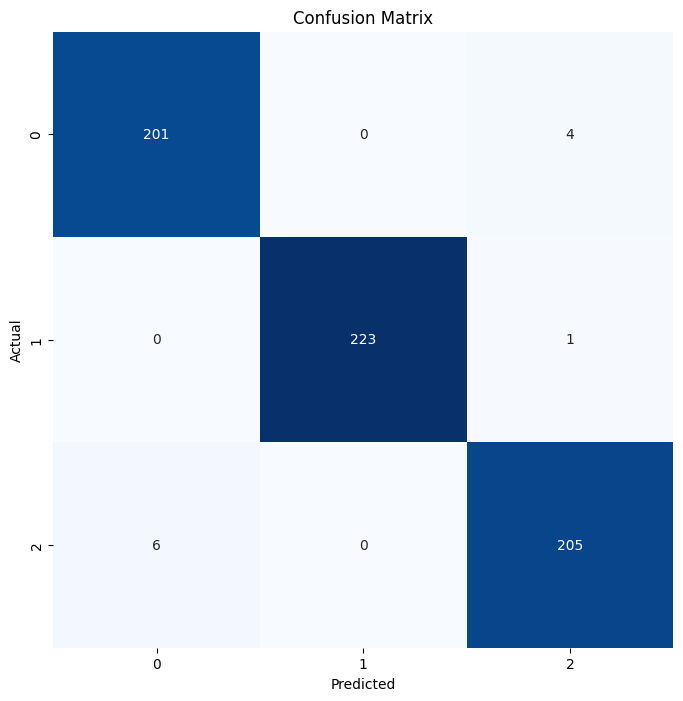

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.97      0.98      0.98       205
           1       1.00      1.00      1.00       224
           2       0.98      0.97      0.97       211

    accuracy                           0.98       640
   macro avg       0.98      0.98      0.98       640
weighted avg       0.98      0.98      0.98       640



In [83]:
y_pred = np.array(list(map(lambda x: np.argmax(x), model.predict(X_test))))
y_test = np.argmax(y_test, axis=1)


cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)